[Hybrid] rows=145 | range=2020-02-09 → 2022-11-13 | category=Furniture


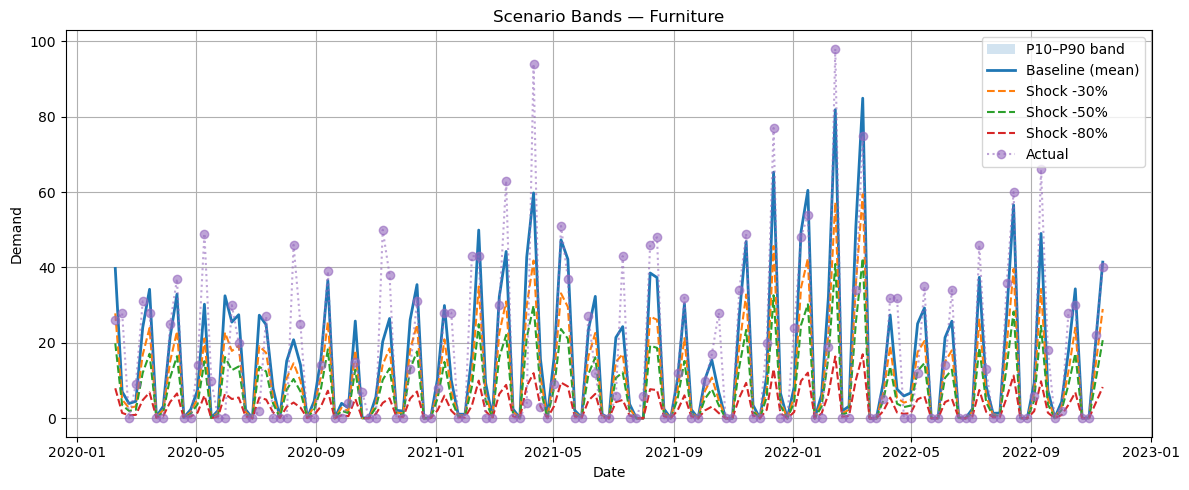

[Saved] manager_report_charts/scenario_bands_Furniture.png


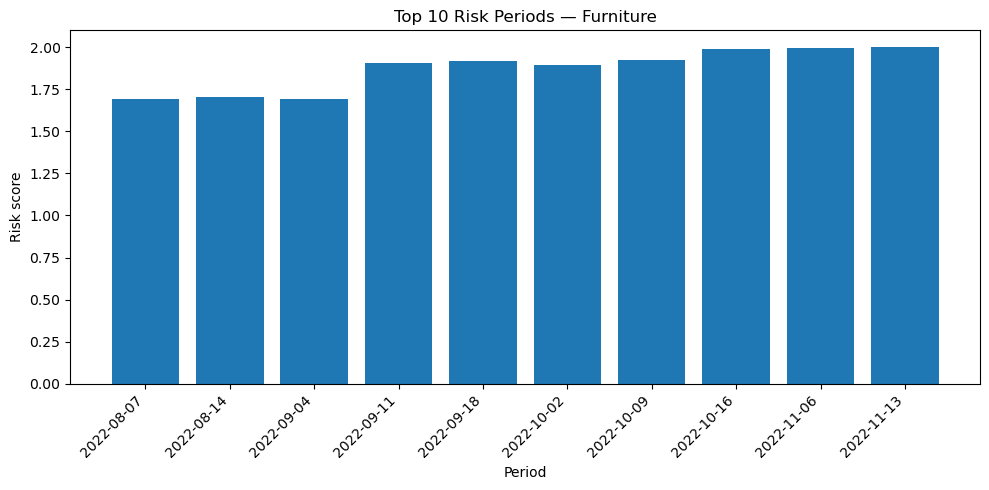

[Saved] manager_report_charts/top10_risk_Furniture.png

[Top 10 Risk Periods]
      date  risk_score  outside_flag    width
2022-08-07    1.691293             1 0.485320
2022-08-14    1.701244             1 0.492307
2022-09-04    1.694154             1 0.487329
2022-09-11    1.906645             1 0.636508
2022-09-18    1.916377             1 0.643340
2022-10-02    1.896069             1 0.629083
2022-10-09    1.921516             1 0.646948
2022-10-16    1.987557             1 0.693312
2022-11-06    1.996693             1 0.699726
2022-11-13    2.000000             1 0.702047


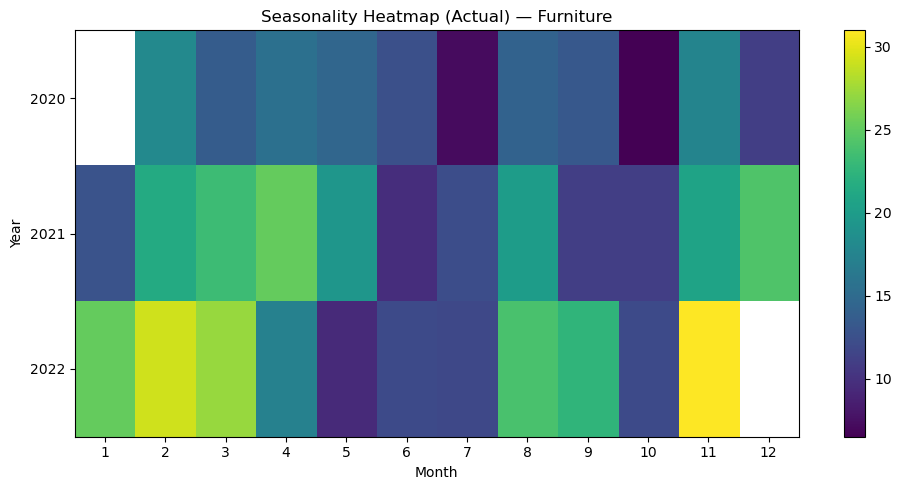

[Saved] manager_report_charts/seasonality_heatmap_Furniture.png


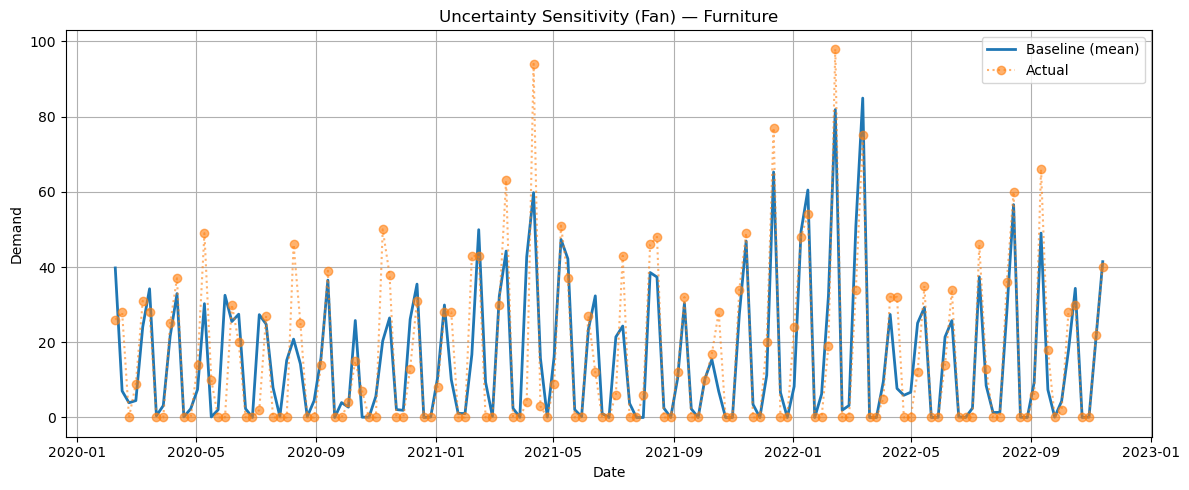

[Saved] manager_report_charts/uncertainty_sensitivity_Furniture.png


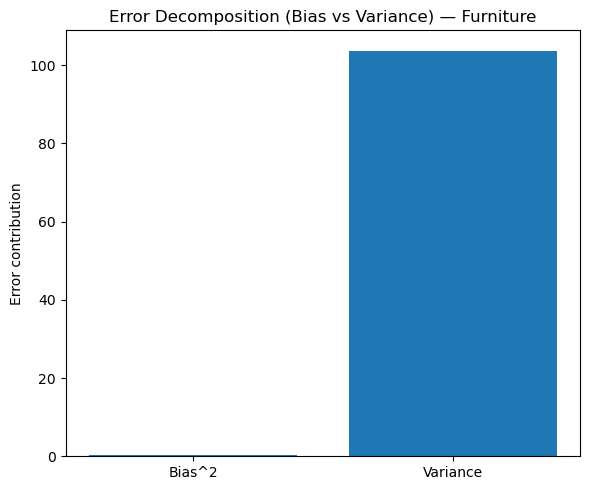

[Saved] manager_report_charts/error_decomposition_Furniture.png
[Error Decomposition] bias=-0.518 | bias^2=0.268 | variance=103.727


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# ======================
# CONFIG
# ======================
HYB_PATH = "/Users/jinnanut/Desktop/Code/MCR+ML_summary_weekly.xlsx" 
SHEET    = "Weekly"                     
OUTPUT   = Path("./manager_report_charts")
OUTPUT.mkdir(parents=True, exist_ok=True)

# pick one category to illustrate
CAT_TO_PLOT = None

# shock magnitudes for scenario overlays (percent changes of mean)
DEMAND_SHOCKS = [-0.30, -0.50, -0.80]  # -30%, -50%, -80%

# sensitivity multipliers on band half-width (fan chart)
SENSITIVITY_FACTORS = [0.7, 0.85, 1.0, 1.15, 1.3]


# ======================
# Set Function
# ======================
def _std_cols(df):
    """Normalize column names and ensure required columns exist."""
    d = df.copy()
    d.columns = d.columns.str.strip().str.lower()
    if "date" not in d.columns:
        raise ValueError("Input must contain 'date'")
    for col in ["mean","p10","p90"]:
        if col not in d.columns:
            raise ValueError(f"Input must contain '{col}'")
    d["date"] = pd.to_datetime(d["date"])
    if "actual" in d.columns:
        d["actual"] = pd.to_numeric(d["actual"], errors="coerce")
    return d

def _pick_category(df, cat=None):
    """If there is a 'category' column, filter to one category; otherwise return as is."""
    if "category" not in df.columns:
        return df, None
    cats = sorted(df["category"].dropna().unique())
    if not cats:
        return df, None
    chosen = cat if cat in cats else cats[0]
    return df[df["category"] == chosen].sort_values("date"), chosen

def _ensure_sorted(df):
    return df.sort_values("date").reset_index(drop=True)


# ======================
# LOAD
# ======================
df_hyb = pd.read_excel(HYB_PATH, sheet_name=SHEET)
df_hyb = _std_cols(df_hyb)
df_hyb, picked_cat = _pick_category(df_hyb, CAT_TO_PLOT)
df_hyb = _ensure_sorted(df_hyb)

print(f"[Hybrid] rows={len(df_hyb)} | "
      f"range={df_hyb['date'].min().date()} → {df_hyb['date'].max().date()} | "
      f"{'category='+str(picked_cat) if picked_cat else 'single series'}")


# ======================
# 1) SCENARIO BANDS (baseline + shocks)
# ======================
def plot_scenario_bands(df, shocks, title_prefix="Scenario Bands"):
    df = df.copy()
    # baseline
    t = df["date"]
    mean = df["mean"].astype(float)
    p10  = df["p10"].astype(float)
    p90  = df["p90"].astype(float)

    plt.figure(figsize=(12,5))
    # MC band
    plt.fill_between(t, p10, p90, alpha=0.2, label="P10–P90 band")
    # baseline mean
    plt.plot(t, mean, linewidth=2, label="Baseline (mean)")

    # shock overlays (as offsets on the mean)
    for s in shocks:
        shock_series = mean * (1.0 + s)
        label = f"Shock {int(s*100)}%"
        plt.plot(t, shock_series, linestyle="--", label=label)

    if "actual" in df.columns and df["actual"].notna().any():
        plt.plot(t, df["actual"], linestyle=":", marker="o", alpha=0.6, label="Actual")

    title = f"{title_prefix}" + (f" — {picked_cat}" if picked_cat else "")
    plt.title(title)
    plt.xlabel("Date"); plt.ylabel("Demand")
    plt.legend(); plt.grid(True); plt.tight_layout()

    out = OUTPUT / f"scenario_bands{'_'+picked_cat if picked_cat else ''}.png"
    plt.savefig(out, dpi=200)
    plt.show()
    print(f"[Saved] {out}")

plot_scenario_bands(df_hyb, DEMAND_SHOCKS)


# ======================
# 2) TOP-10 RISK PERIODS
#    Risk score = (outside-band flag) + normalized width
# ======================
def plot_top10_risk_periods(df, title_prefix="Top 10 Risk Periods"):
    d = df.copy()
    d["width"] = (d["p90"].astype(float) - d["p10"].astype(float))
    if "actual" in d.columns and d["actual"].notna().any():
        outside = ~((d["actual"] >= d["p10"]) & (d["actual"] <= d["p90"]))
        d["outside_flag"] = outside.astype(int)
    else:
        d["outside_flag"] = 0

    # normalize width (0..1) to combine with outside_flag
    if d["width"].max() > 0:
        d["width_norm"] = (d["width"] - d["width"].min()) / (d["width"].max() - d["width"].min())
    else:
        d["width_norm"] = 0.0

    d["risk_score"] = d["outside_flag"] + d["width_norm"]
    top10 = d.nlargest(10, "risk_score")[["date","risk_score","outside_flag","width"]].sort_values("date")

    plt.figure(figsize=(10,5))
    plt.bar(top10["date"].astype(str), top10["risk_score"])
    plt.xticks(rotation=45, ha="right")
    title = f"{title_prefix}" + (f" — {picked_cat}" if picked_cat else "")
    plt.title(title)
    plt.xlabel("Period"); plt.ylabel("Risk score")
    plt.tight_layout()

    out = OUTPUT / f"top10_risk{'_'+picked_cat if picked_cat else ''}.png"
    plt.savefig(out, dpi=200)
    plt.show()
    print(f"[Saved] {out}")

    # print a small table for the manager
    print("\n[Top 10 Risk Periods]")
    print(top10.to_string(index=False))

plot_top10_risk_periods(df_hyb)


# ======================
# 3) SEASONALITY HEATMAP (by Year x Month, using actual if present else mean)
# ======================
def plot_seasonality_heatmap(df, title_prefix="Seasonality Heatmap"):
    d = df.copy()
    metric = "actual" if "actual" in d.columns and d["actual"].notna().any() else "mean"
    d["year"] = d["date"].dt.year
    d["month"] = d["date"].dt.month
    grid = d.pivot_table(index="year", columns="month", values=metric, aggfunc="mean")

    plt.figure(figsize=(10,5))
    # imshow expects a 2D array; show month order 1..12
    data = grid.reindex(columns=sorted(grid.columns)).values
    plt.imshow(data, aspect="auto")
    plt.colorbar()
    plt.yticks(ticks=range(len(grid.index)), labels=grid.index.astype(str))
    plt.xticks(ticks=range(12), labels=[str(m) for m in range(1,13)])
    title = f"{title_prefix} ({metric.capitalize()})" + (f" — {picked_cat}" if picked_cat else "")
    plt.title(title)
    plt.xlabel("Month"); plt.ylabel("Year")
    plt.tight_layout()

    out = OUTPUT / f"seasonality_heatmap{'_'+picked_cat if picked_cat else ''}.png"
    plt.savefig(out, dpi=200)
    plt.show()
    print(f"[Saved] {out}")

plot_seasonality_heatmap(df_hyb)


# ======================
# 4) UNCERTAINTY SENSITIVITY (fan chart by scaling band half-width)
# ======================
def plot_uncertainty_sensitivity(df, factors, title_prefix="Uncertainty Sensitivity (Fan)"):
    d = df.copy()
    t = d["date"]
    mean = d["mean"].astype(float)
    p10  = d["p10"].astype(float)
    p90  = d["p90"].astype(float)
    half_low  = mean - p10
    half_high = p90  - mean
    half = np.maximum(half_low, half_high)  # symmetric fan around mean based on larger side

    plt.figure(figsize=(12,5))
    plt.plot(t, mean, linewidth=2, label="Baseline (mean)")
    # fan bands
    for f in sorted(factors):
        lo = mean - f * half
        hi = mean + f * half
        plt.fill_between(t, lo, hi, alpha=0.15)

    if "actual" in d.columns and d["actual"].notna().any():
        plt.plot(t, d["actual"], linestyle=":", marker="o", alpha=0.6, label="Actual")

    title = f"{title_prefix}" + (f" — {picked_cat}" if picked_cat else "")
    plt.title(title)
    plt.xlabel("Date"); plt.ylabel("Demand")
    plt.legend(); plt.grid(True); plt.tight_layout()

    out = OUTPUT / f"uncertainty_sensitivity{'_'+picked_cat if picked_cat else ''}.png"
    plt.savefig(out, dpi=200)
    plt.show()
    print(f"[Saved] {out}")

plot_uncertainty_sensitivity(df_hyb, SENSITIVITY_FACTORS)


# ======================
# 5) ERROR DECOMPOSITION (bias^2 vs variance)
# ======================
def plot_error_decomposition(df, title_prefix="Error Decomposition (Bias vs Variance)"):
    d = df.copy()
    if "actual" not in d.columns or d["actual"].isna().all():
        print("[Warn] No 'actual' in dataframe; skipping error decomposition.")
        return

    err = (d["mean"] - d["actual"]).astype(float)
    bias = float(np.mean(err))
    var  = float(np.var(err, ddof=1)) if len(err) > 1 else 0.0
    bias2 = bias**2

    plt.figure(figsize=(6,5))
    plt.bar(["Bias^2","Variance"], [bias2, var])
    title = f"{title_prefix}" + (f" — {picked_cat}" if picked_cat else "")
    plt.title(title)
    plt.ylabel("Error contribution")
    plt.tight_layout()

    out = OUTPUT / f"error_decomposition{'_'+picked_cat if picked_cat else ''}.png"
    plt.savefig(out, dpi=200)
    plt.show()
    print(f"[Saved] {out}")

    print(f"[Error Decomposition] bias={bias:.3f} | bias^2={bias2:.3f} | variance={var:.3f}")

plot_error_decomposition(df_hyb)
